<h1>Feature Clustering</h1>

<h2>Manuel Valle Torre</h2>

This notebook contains the workflow and ideas of my thesis. The main goal is to summarize reviews by the features that the users care about and how they express about them, without focus on rating. For this, we propose the use of clustering by review in a full category of products, and not by individual products. In other words, our theory is that reviews that express interest in technical detail will differ from those with emotional connotations, as well as those that state irrelevant product characteristics, such as vendor or shipping experience. 

* First, we need to extract certain features from the reviews and assign them a numerical value, in this case it is done via document embedding.
* Second, we cluster those vectors into the mentioned groups.
* Third, we represent the summaries in a useful way for the user.



<h2>Feature Extraction using Doc2vec</h2>

In this section, we go through the process of training and testing a doc2vec model from Amazon User Reviews. The goal is to create high-dimensional vectors with latent features of the reviews. Doc2vec is a neural network that creates document (review) embeddings in a vector space. This is a high dimensional space, for example 100 dimensions. These vectors will later be used to try and cluster the reviews by the features the users care about and how they write about them.

In [1]:
from gensim import models
from random import shuffle
from nltk.tokenize import word_tokenize
import json
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim.models.doc2vec
import numpy as np
from pprint import pprint

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


The data is extracted from a json file obtained from the UCSD website, http://jmcauley.ucsd.edu/data/amazon/ and it's formatted like this:

{

  "reviewerID": "A2SUAM1J3GNN3B",
  
  "asin": "0000013714",
  
  "reviewerName": "J. McDonald",
  
  "helpful": [2, 3],
  
  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",
  
  "overall": 5.0,
  
  "summary": "Heavenly Highway Hymns",
  
  "unixReviewTime": 1252800000,
  
  "reviewTime": "09 13, 2009"
  
}


In [2]:
data = []
with open('Pet_Supplies_5.json') as f:
    for line in f:
        data.append(json.loads(line))

Then the reviews have to be introduced into a LabeledSentence format consisting of unicode separate words (which form the "documents" of doc2vec) and a label. In this case, the label is created by adding the reviewer id with the product id from Amazon, such as 'A3UF8X1S0ZZ8KR|B000WUVZCK'. The text is tokenized and we only take in account reviews longer than 20 tokens to avoid meaningless text like "perfect", "just as expected", "not what we wanted", etc.

In [3]:
sentences = []

for l in range(len(data)):
    sentence = models.doc2vec.LabeledSentence(
        words = word_tokenize(data[l]['reviewText'].lower()), 
        tags = [data[l]['reviewerID']+'|'+data[l]['asin']])
    if len(sentence[0]) > 20:
        sentences.append(sentence)

print('Total reviews introduced: ', len(sentences))

Total reviews introduced:  155847


This is how a Labeled Sentence looks like:

In [4]:
sentences[0]

LabeledSentence(words=['i', 'purchased', 'the', 'trilogy', 'with', 'hoping', 'my', 'two', 'cats', ',', 'age', '3', 'and', '5', 'would', 'be', 'interested', '.', 'the', '3', 'yr', 'old', 'cat', 'was', 'fascinated', 'for', 'about', '15', 'minutes', 'but', 'when', 'the', 'same', 'pictures', 'came', 'on', ',', 'she', 'got', 'bored', '.', 'the', '5', 'year', 'old', 'watched', 'for', 'about', 'a', 'few', 'minutes', 'but', 'then', 'walked', 'away', '.', 'it', 'is', 'possible', 'that', 'because', 'we', 'have', 'a', 'wonderful', 'courtyard', 'full', 'of', 'greenery', 'and', 'trees', 'and', 'one', 'of', 'my', 'neighbors', 'has', 'a', 'bird', 'feeder', ',', 'that', 'there', 'is', 'enough', 'going', 'on', 'outside', 'that', 'they', 'prefer', 'real', 'life', 'versus', 'a', 'taped', 'version', '.', 'i', 'will', 'more', 'than', 'likely', 'pass', 'this', 'on', 'to', 'a', 'friend', 'who', 'has', 'cats', 'that', 'do', "n't", 'have', 'as', 'much', 'wildlife', 'to', 'watch', 'as', 'mine', 'do', '.'], tags

Note: If models are already available, skip to model loading. If not, continue here

Then we build the model with parameters tuned by trial and error, initially based on the inforamtion established in the paper of the experiment of Le & Mikolov ["Distributed Representations of Sentences and Documents"](http://cs.stanford.edu/~quocle/paragraph_vector.pdf), and an example by gensim on IMDB [doc2vec & IMDB](http://localhost:8888/notebooks/GitHub/gensim/docs/notebooks/doc2vec-IMDB.ipynb):

* `size` of 100-dimensional vectors, as the 400d vectors of the paper don't seem to offer much benefit on this task
* The `window` is kept at 10 since it showed good performance with documents of similar size
* Similarly, frequent word subsampling (restricting the amount of times that words can appear) seems to decrease sentiment-prediction accuracy, so it's left out.
* `dm=0` and `dbow_words=1` means 'skip-gram' (PV-DBOW) mode, a distributed bag of words
* `dm=1` defines the training algorithm 'distributed memory' (PV-DM) 
* A `min_count=3` saves quite a bit of model memory, discarding only words that only appear twice or once (and are thus no more expressive than the unique-to-each doc vectors themselves)
* More `workers` allow faster processing when possibe
* `alpha` is the initial learning rate, and will decrease linearly to min_alpha. In this case we keep it fixed to avoid decay.

In [5]:
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

model_dm = models.Doc2Vec(dm=1, dm_mean=1, size=100, window=10, min_count=3, workers=multiprocessing.cpu_count(), alpha=.025, min_alpha=.025)
#model.build_vocab(sentences)

model_dbow = models.Doc2Vec(dm=0, dbow_words=1, size=100, window=10, min_count=3, workers=multiprocessing.cpu_count())


In [6]:
model_dbow.build_vocab(sentences)
print(str(model_dbow))

model_dm.build_vocab(sentences)
print(str(model_dm))

Doc2Vec(dbow+w,d100,n5,w10,mc3,s0.001,t8)
Doc2Vec(dm/m,d100,n5,w10,mc3,s0.001,t8)


In order to be sure there are no overlapping tags, here we check whether the amount of created vectors us the same as the amount of documents put into each model.

In [7]:
assert len(model_dbow.docvecs) == len(sentences), "there are overlapping section titles! {0} docvecs and {1} documents".format(len(model.docvecs), len(sentences))
assert len(model_dm.docvecs) == len(sentences), "there are overlapping section titles! {0} docvecs and {1} documents".format(len(model.docvecs), len(sentences))

Here we train the dbow model for a set number of iterations

In [8]:
for epoch in range(10):
    print("Training doc2vec_dbow model, epoch {}".format(epoch))
    #Randomly shuffle sentences for better training
    shuffle(sentences)    
    model_dbow.train(sentences)
    model_dbow.min_alpha = model_dbow.alpha # fix the learning rate, no decay

Training doc2vec_dbow model, epoch 0
Training doc2vec_dbow model, epoch 1
Training doc2vec_dbow model, epoch 2
Training doc2vec_dbow model, epoch 3
Training doc2vec_dbow model, epoch 4
Training doc2vec_dbow model, epoch 5
Training doc2vec_dbow model, epoch 6
Training doc2vec_dbow model, epoch 7
Training doc2vec_dbow model, epoch 8
Training doc2vec_dbow model, epoch 9


Now the dm model

In [9]:
for epoch in range(10):
    print("Training doc2vec_dm model, epoch {}".format(epoch))    
    #Randomly shuffle sentences for better training
    shuffle(sentences)    
    model_dm.train(sentences)
    model_dm.min_alpha = model_dm.alpha # fix the learning rate, no decay

Training doc2vec_dm model, epoch 0
Training doc2vec_dm model, epoch 1
Training doc2vec_dm model, epoch 2
Training doc2vec_dm model, epoch 3
Training doc2vec_dm model, epoch 4
Training doc2vec_dm model, epoch 5
Training doc2vec_dm model, epoch 6
Training doc2vec_dm model, epoch 7
Training doc2vec_dm model, epoch 8
Training doc2vec_dm model, epoch 9


Then we save both models and test the similarity of a document with itself, as a naive sanity check

In [4]:
#model_dm.save("PetRev_dm10epoch.doc2vec")
#model_dbow.save("PetRev_dbow10epoch.doc2vec")

model_dm = Doc2Vec.load("PetRev_dm10epoch.doc2vec")
model_dbow = Doc2Vec.load("PetRev_dbow10epoch.doc2vec")

In [7]:
test_dbow = model_dbow.docvecs.similarity( d1='A3UF8X1S0ZZ8KR|B000WUVZCK', d2='A3UF8X1S0ZZ8KR|B000WUVZCK')
test_dm = model_dm.docvecs.similarity( d1='A3UF8X1S0ZZ8KR|B000WUVZCK', d2='A3UF8X1S0ZZ8KR|B000WUVZCK')
print('Similarity of the document A3UF8X1S0ZZ8KR|B000WUVZCK to itself is ', test_dbow, ' for dbow, and ', test_dm, 'for dm.')

Similarity of the document A3UF8X1S0ZZ8KR|B000WUVZCK to itself is  1.0  for dbow, and  1.0 for dm.


Now we create a dictionary with the labels as keys and text as value, for easier reading and qualitative analysis

In [5]:
inverted_sentences = {}

for x in range(len(sentences)):
    a = sentences[x][1][0]
    b = ' '.join(sentences[x][0])
    inverted_sentences[a] = b

Here we can get a given ID and their most similar sentences by both models. 

In [6]:
dbow_sim = model_dbow.docvecs.most_similar(positive=["A3UF8X1S0ZZ8KR|B000WUVZCK"], topn=500)
dm_sim = model_dm.docvecs.most_similar(positive=["A3UF8X1S0ZZ8KR|B000WUVZCK"], topn=500)

In [226]:
print('--Top 5 similar reviews in dbow to: ', inverted_sentences["A3UF8X1S0ZZ8KR|B000WUVZCK"]+'\n')
for x in range(5):
    print('ID: ', dbow_sim[x][0], ' Review: ',inverted_sentences[dbow_sim[x][0]]+'\n')

print('--Top 5 similar reviews in dm to: ', inverted_sentences["A3UF8X1S0ZZ8KR|B000WUVZCK"]+'\n')
for x in range(5):
    print('ID: ', dm_sim[x][0], ' Review: ',inverted_sentences[dm_sim[x][0]]+'\n')

--Top 5 similar reviews in dbow to:  these are one of my two cats favorite treats . as soon as they hear the bag crinkle they come running !

ID:  A2ZV8W46FZWCLJ|B008PNN8C6  Review:  my cats adore these , all i have to do is rattle the package and they come running . definitely a hit !

ID:  A165CAFHYB29EY|B008FXKOI2  Review:  my cats love these treats . they run from all over when they hear the bag rattle . and they seem to be good for them as well .

ID:  A1AHLKY5GIC0ZX|B0012KB4U2  Review:  i stocked up on these as it is the one treat besides catnip that our cats love . the minute they hear the bag rattle , the 2 of them come running .

ID:  A1NLZDMM0GS268|B0029O10P4  Review:  as soon as they hear me pick up the bag , the cats come running ! they absolutely love these treats ! ! i put these on subscription so my spoiled kitties wo n't run out . =^..^=

ID:  A16GHVHVCMN80Z|B00BP2CKXW  Review:  i have three cats and they all love these treats . as soon as i open the package , they run 

Similar procedure with a random sentence, for curiosity

In [201]:
r = np.random.randint(len(sentences))

dbow_sim2 = model_dbow.docvecs.most_similar(positive=sentences[r][1], topn=5)
print('Top 5 similar reviews in dbow to: ', inverted_sentences[sentences[r][1][0]]+'\n')
for x in range(5):
    print('ID: ', dbow_sim2[x][0], ' Review: ',inverted_sentences[dbow_sim2[x][0]]+'\n')
    
dm_sim2 = model_dm.docvecs.most_similar(positive=sentences[r][1], topn=5)
print('Top 5 similar reviews in dm to: ', inverted_sentences[sentences[r][1][0]]+'\n')
for x in range(5):
    print('ID: ', dm_sim2[x][0], ' Review: ',inverted_sentences[dm_sim2[x][0]]+'\n')

Top 5 similar reviews in dbow to:  i am a fan of marineland eclipse tanks mainly because of the bio-wheel in addition to regular filter pads . it is important to realize that the biowheel does not need cleaning when it starts to look a little gunky , that 's how it 's supposed to look and works best . it adds healthy bacteria into the tank , eliminating the need for cultured gravel . do n't clean or replace the biowheel ! i cycled this tank for a couple of weeks before adding fish . it 's good size for a single betta or school of small fish . perfect for dwarf frogs . the filter does a good job without too strong a current in my opinion . light is okay , nothing special . only problem that you can say this tank has is the design that you do need to lift the entire lid , not just the door , for best feeding . it 's not difficult or a hassle for me doing it that way . you can sneak the food in through the door but it 's a bit tricky . the door is only useful for filter changing really . 

In here, we can infer the vector of a given sentence (separated by words like at the beginning) and test how similar it is to others. This is important to get vectors from new sentences that were not in the training set for the model. In this case we try it with a sentence that is in the dataset, to see which ones are the most similar. The first sentence should be itself.

Higher steps in the inference process will achieve a better similarity score to itself, while reducing it to the others.

In [9]:
x = np.random.randint(len(sentences))

print('ID = ',sentences[x][1][0], ' text = ', inverted_sentences[sentences[x][1][0]])

inferred_docvec = model_dbow.infer_vector(word_tokenize(inverted_sentences[sentences[x][1][0]]), steps=5000, alpha = 0.01)
pprint('%s:\n %s' % (model_dbow, model_dbow.docvecs.most_similar([inferred_docvec], topn=5)))

inferred_docvec = model_dm.infer_vector(word_tokenize(inverted_sentences[sentences[x][1][0]]), steps=5000, alpha = 0.01)
pprint('%s:\n %s' % (model_dm, model_dm.docvecs.most_similar([inferred_docvec], topn=5)))

ID =  A277TO3PKKNYDH|B00I18UVO8  text =  though my dog loves these treats i 've noticed an increase in redness in her gums since we started giving them to her . we both love jerky treats , me because they 're not full of fillers and her because they 're yummy . but these are pretty processed compared to other treats from this brand and i 'd like to avoid giving my dog sugar , which these include.if you do n't mind giving your dog added sugar in their treats/food i think these will please your pooch as much as mine . but unless you 're brushing their teeth regularly i 'd suggest trying the waggin train chicken jerky tenders instead .
('Doc2Vec(dbow+w,d100,n5,w10,mc3,s0.001,t8):\n'
 " [('A277TO3PKKNYDH|B00I18UVO8', 0.958854615688324), "
 "('A29LEKAPSKY1PW|B003C5PD9I', 0.5610634088516235), "
 "('A3DG82ZKOFAOAE|B008EFHCFE', 0.552722692489624), "
 "('A29LEKAPSKY1PW|B00A726YK6', 0.537396252155304), "
 "('A3QDITMY3OOYRP|B001E52YO0', 0.5226117372512817)]")
('Doc2Vec(dm/m,d100,n5,w10,mc3,s0.001

Now we can try to visualize the vector as a line and compare it to its word-based inference.

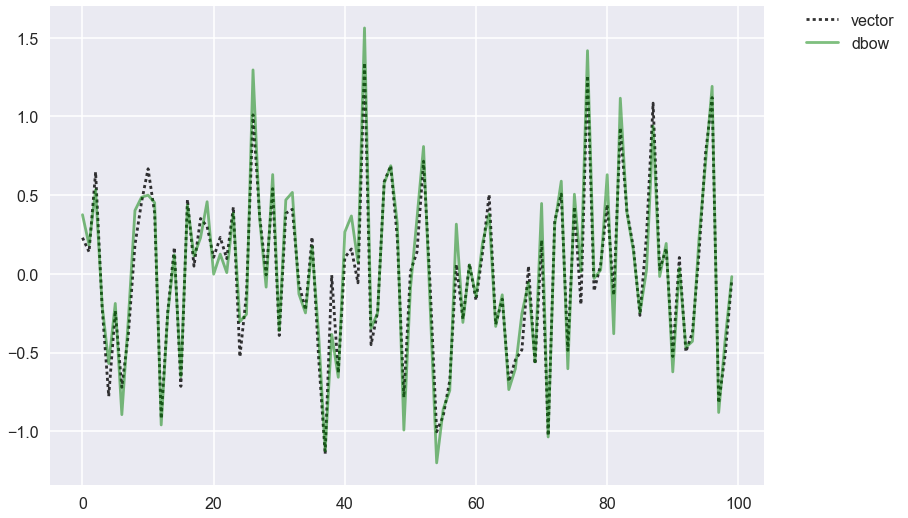

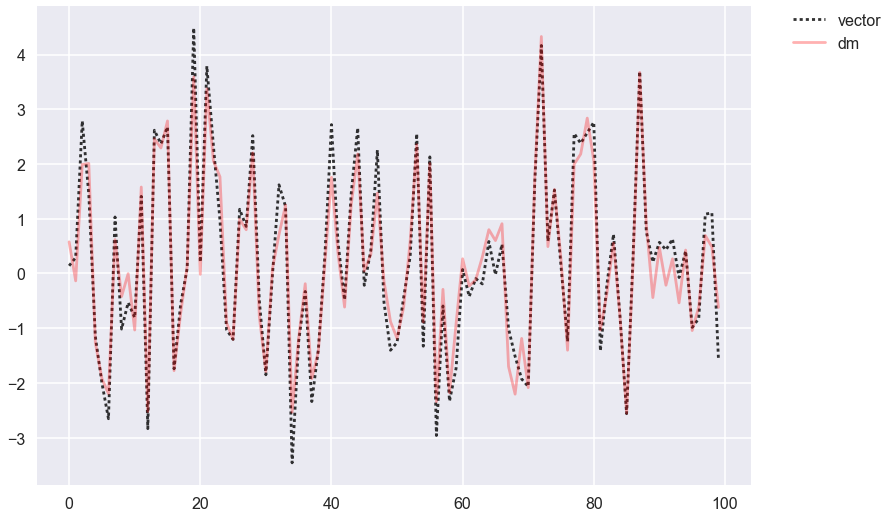

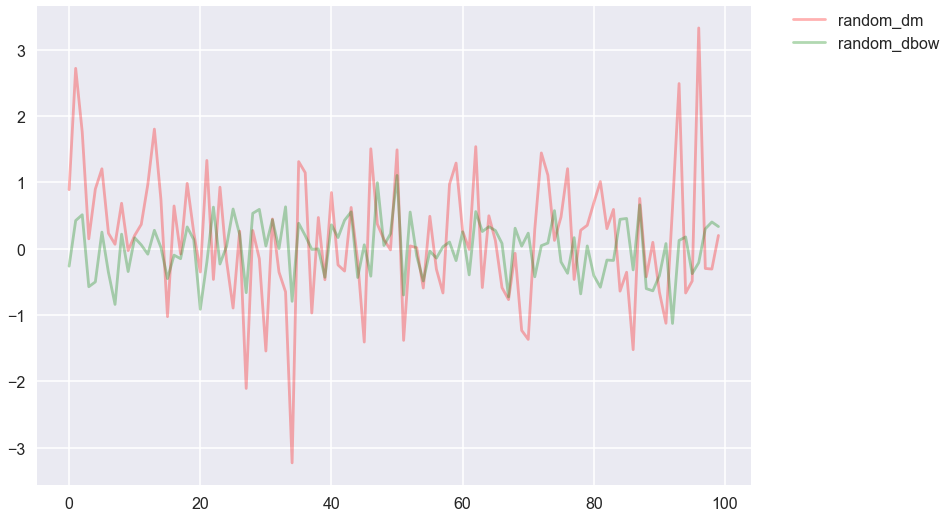

In [231]:
# We can choose any sentence and print its vector, as well as the inferred vector of the review's words. 
# Then we can also plot the vector as a line and compare it to the model inference of itself.

#print(model_dbow.docvecs[sentences[x][1][0]])
#print(model_dm.infer_vector(word_tokenize(inverted_sentences[sentences[x][1][0]]), steps=1000, alpha = 0.01))
#model_dbow.docvecs[sentences[x][1][0]] - model_dm.infer_vector(word_tokenize(inverted_sentences[sentences[x][1][0]]))

# With dbow
import matplotlib.pyplot as plt
plt.plot(model_dbow.docvecs[sentences[x][1][0]], alpha = 0.8, linestyle='dotted', color='black', label='vector')
plt.plot(model_dbow.infer_vector(word_tokenize(inverted_sentences[sentences[x][1][0]]), steps=5000, alpha = 0.01), alpha = 0.5, color = 'green', label = 'dbow')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# With dm
plt.plot(model_dm.docvecs[sentences[x][1][0]], alpha = 0.8, linestyle='dotted', color='black', label='vector')
#plt.plot(model_dm.infer_vector(word_tokenize('Digitalisation is rapidly changing the world. Besides looking at the past, companies need to know what is happening now and anticipate what is going to happen. Large data volumes, data variety and the speed of data are only increasing and it is our mission to ensure organisations have as much relevant and valuable information as possible'), steps=5000, alpha = 0.01), alpha = 0.3, color='green', label = 'random')
plt.plot(model_dm.infer_vector(word_tokenize(inverted_sentences[sentences[x][1][0]]), steps=5000, alpha = 0.01), alpha = 0.3, color='red', label = 'dm')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Some unrelated sentence by both models
plt.plot(model_dm.infer_vector(word_tokenize('Digitalisation is rapidly changing the world. Besides looking at the past, companies need to know what is happening now and anticipate what is going to happen. Large data volumes, data variety and the speed of data are only increasing and it is our mission to ensure organisations have as much relevant and valuable information as possible'), steps=5000, alpha = 0.01), alpha = 0.3, color='red', label = 'random_dm')
plt.plot(model_dbow.infer_vector(word_tokenize('Digitalisation is rapidly changing the world. Besides looking at the past, companies need to know what is happening now and anticipate what is going to happen. Large data volumes, data variety and the speed of data are only increasing and it is our mission to ensure organisations have as much relevant and valuable information as possible'), steps=5000, alpha = 0.01), alpha = 0.3, color='green', label = 'random_dbow')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

<h2>Clustering</h2>
In this section we perform graphical comparisons of distinct clustering algorithms to check parameters and behavior, as well as some exploratory analysis. 

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
from mpl_toolkits.mplot3d import Axes3D
import hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

Create sets of 2, 3 and X dimensions with a number of instances for clustering and exploration.

In [178]:
# For a 2 dimensional plot
vectors = []
dimensions = 2
for x in range(10000):      
    vector = []
    for y in range(dimensions):
        #id = sentences[x][1][0]
        a = model_dbow.docvecs[sentences[x][1][0]][y]    
        vector.append(a)
    vectors.append(vector)

# For a 3 dimensional plot
vectors3d = []    
dimensions = 3
for x in range(10000):      
    vector = []
    for y in range(dimensions):
        #id = sentences[x][1][0]
        a = model_dbow.docvecs[sentences[x][1][0]][y]    
        vector.append(a)
    vectors3d.append(vector)

# For a X dimensional analysis, can be plotted on both 2d and 3d for visualization
vectorsXd = []
dimensions = 100
for x in range(500):      
    vector = []
    for y in range(dimensions):
        a = model_dbow.docvecs[sentences[x][1][0]][y]    
        vector.append(a)
    vectorsXd.append(vector)
    
# Convert to arrays
data = np.array(vectors)
data3d = np.array(vectors3d)
dataXd = np.array(vectorsXd)

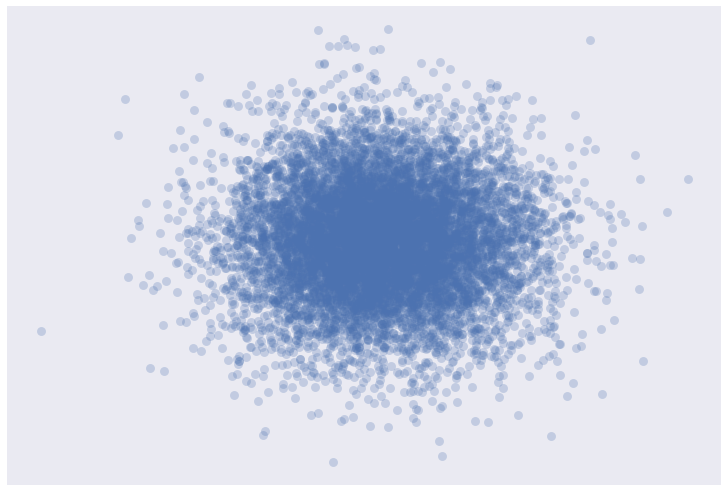

In [170]:
plt.scatter(data.T[0], data.T[1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

These are the plotting functions, they take the data introduced, execute the clustering algorithms, and map the first 2 or 3 dimensions of the data, respectively, colored by cluster. The main algorithms accepted are from sklearn, with their parameters: 
* plot_clusters(data, cluster.KMeans, (), {'n_clusters':6})
* plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})
* plot_clusters(data, cluster.MeanShift, (0.175,), {'cluster_all':False})
* plot_clusters(data, cluster.SpectralClustering, (), {'n_clusters':6})
* plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})
* plot_clusters(data, cluster.DBSCAN, (), {'eps':0.025})
* plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':15})

Review documentation if necessary.

In [171]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    clusters = np.unique(labels).max()+1
    palette = sns.color_palette('bright', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    frame.set_xlabel('x_axis')
    frame.set_ylabel('y_axis')
    plt.text(-1.5, -1.2, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    plt.text(-1.5, -1.4, 'Number of clusters ={}'.format(str(clusters)), fontsize=14)
    plt.ylim([-2,2])
    plt.xlim([-2,2])
    
def plot_clusters3d(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    clusters = np.unique(labels).max()+1
    palette = sns.color_palette('bright', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x_axis')
    ax.set_ylabel('y_axis')
    ax.scatter(data.T[0], data.T[1], data.T[2], zdir='y', c=colors, **plot_kwds)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    ax.text(-1.5,-1.3,-1.3, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    ax.text(-1.5,-1.5,-1.5, 'Number of clusters ={}'.format(str(clusters)), fontsize=14)
    

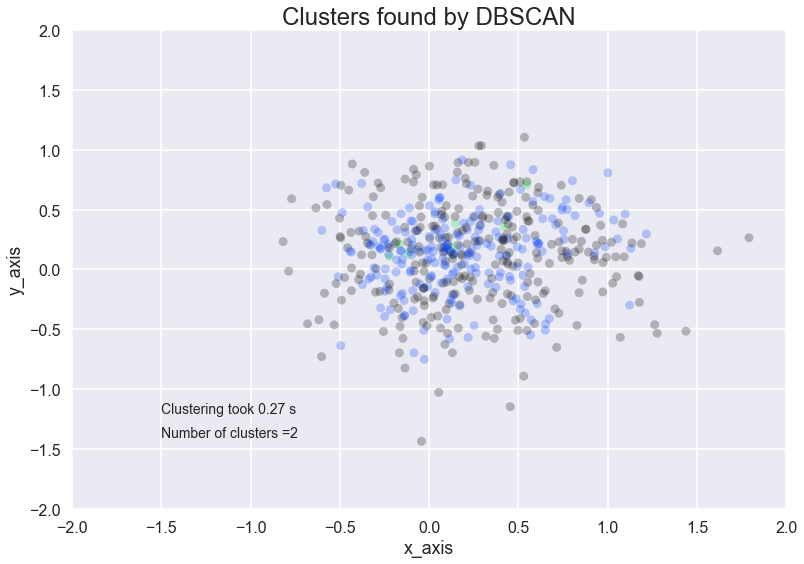

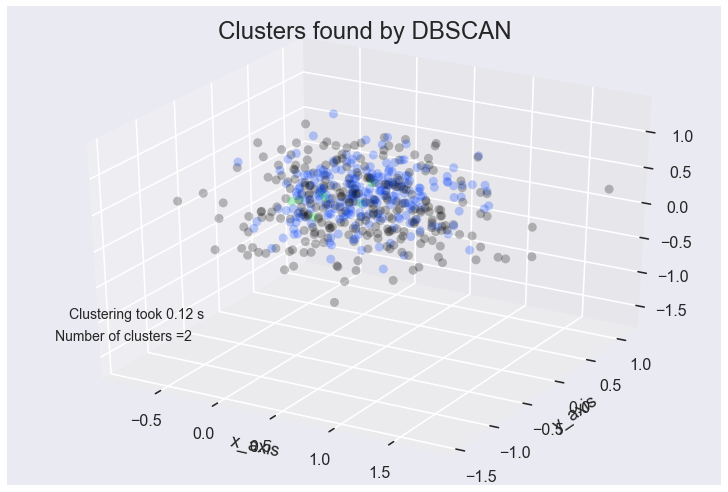

In [245]:
#plot_clusters(dataXd,  cluster.KMeans, (), {'n_clusters':6})
#plot_clusters(data,  hdbscan.RobustSingleLinkage, (), {'cut':0.15, 'k':30})
#plot_clusters(dataXd,  cluster.KMeans, (), {'n_clusters':6})
plot_clusters(dataXd,  cluster.DBSCAN, (), {'eps':4.3, 'min_samples':3})

#plot_clusters3d(dataXd,  cluster.KMeans, (), {'n_clusters':4})
#plot_clusters3d(dataXd,  cluster.KMeans, (), {'n_clusters':6})
#plot_clusters3d(data3d,  hdbscan.RobustSingleLinkage, (), {'cut':0.2, 'k':30})


#plot_clusters(data, cluster.DBSCAN, (), {'eps':0.06, 'min_samples':3})#, 'metric':'euclidean'})
plot_clusters3d(dataXd, cluster.DBSCAN, (), {'eps':4.3, 'min_samples':3})#, 'metric':'euclidean'})

It doesn't look very good, it's all noisy in a cloud thanks to the `curse of dimentionality`. Let's try to get the most and least similar 500 vectors from a given sentence, and try to cluster and plot them using their full dimentions. Below, we do the same algorithm and same parameters but with the 500 least similar sentences to the same vector.

In [173]:
dbow_sim = model_dbow.docvecs.most_similar(positive=["A3UF8X1S0ZZ8KR|B000WUVZCK"], topn=500)
dbow_dif = model_dbow.docvecs.most_similar(negative=["A3UF8X1S0ZZ8KR|B000WUVZCK"], topn=500)

In [180]:
sim_vectorsXd = []
dimensions = 100
for x in range(len(dbow_sim)):      
    vector = []
    for y in range(dimensions):
        a = model_dbow.docvecs[dbow_sim[x][0]][y]    
        vector.append(a)
    sim_vectorsXd.append(vector)

dif_vectorsXd = []
for x in range(len(dbow_dif)):      
    vector = []
    for y in range(dimensions):
        a = model_dbow.docvecs[dbow_dif[x][0]][y]    
        vector.append(a)
    dif_vectorsXd.append(vector)
    
# Convert to arrays
sim_dataXd = np.array(sim_vectorsXd)
dif_dataXd = np.array(dif_vectorsXd)

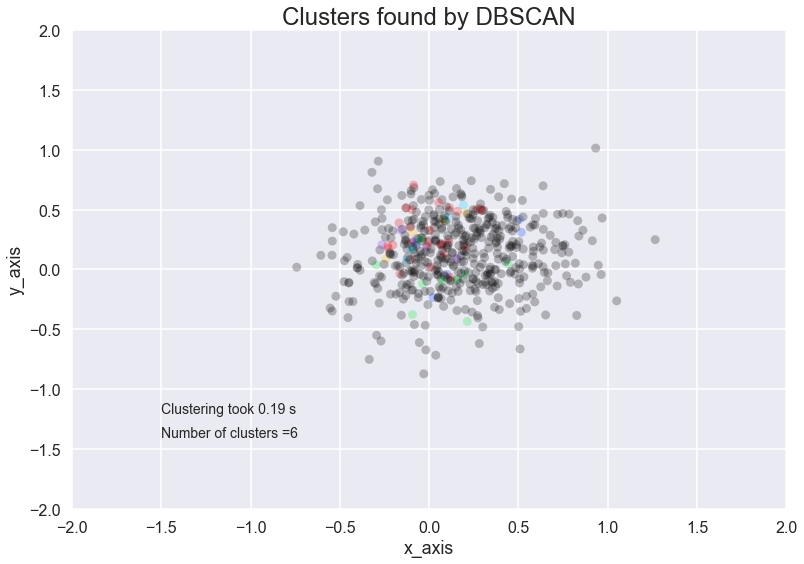

In [259]:
plot_clusters(sim_dataXd,  cluster.DBSCAN, (), {'eps':2.62, 'min_samples':3})
#plot_clusters(sim_dataXd,  hdbscan.HDBSCAN, (), {'min_cluster_size':4})

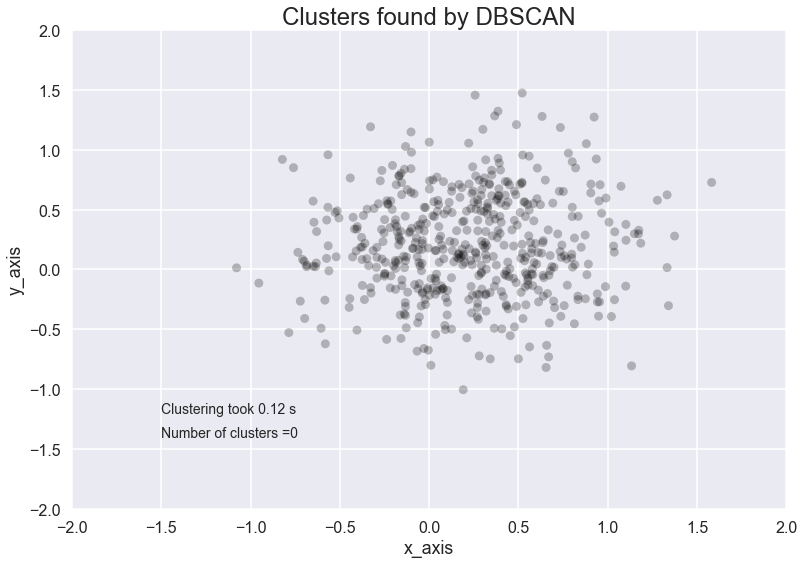

In [260]:
plot_clusters(dif_dataXd, cluster.DBSCAN, (), {'eps':2.62, 'min_samples':3})
#plot_clusters(dif_dataXd,  hdbscan.HDBSCAN, (), {'min_cluster_size':4})

As expected, with the same parameters, there is better behavior with the similar vectors on their full dimentionality using DBSCAN or HDBSCAN. But the clusters are very small and covered in noise. Some approaches to deal with high-dimensionality focus on using the dimentions that describe the highest variance, those that may contain the clusters. On other cases, dimensions are reduced by adding their effects, reducing 2 or more into only one. In this case, since we argue that clusters are supposed to be in different dimensions, given that users focus on different features, we turn to subspace clustering. 

<h1>Subspace Clustering</h1>

Subspace clustering attempts to find clusters in different subspaces of the dataset. Subspaces consist of less dimensions than the full dataset, while they are part of it. For example, a line is a subspace of a plane.

First thigs first, subspaces. Suppose that _V_ is a vector space and _W_ is a subset of _V_, _W_ ⊆ _V_. Endow _W_ with the same operations as _V_. Then _W_ is a subspace if and only if three conditions are met (read more at [Beezer](http://linear.ups.edu/html/fcla.html)).
* _W_ is nonempty, _W_ ≠ ∅.
* If _x_∈_W_ and _y_∈_W_, then (_x_ + _y_)∈_W_.
* If α∈_C_ and _x_∈_W_, then α_x_∈_W_.

On the other hand, the clustering algorithms are different than regular clustering in full space, they vary not only on how they classify instances but how they tackle the subspaces. There are two main reviews on Subspace Clustering (SSC), *Subspace Clustering for High Dimensional Data: A Review* and *Evaluating Clustering in Subspace Projections of High Dimensional Data*. 

The first one divides the algorithms in two main groups, Bottom Up vs Top Down, in a very broad sense this means: 

* Bottom Up method takes advantage of the downward closure property of density, which means that if there are dense units in k dimensions, there are dense units in all (k − 1) dimensional projections. The examples are: CLIQUE, ENCLUS, MAFIA, CBF, CLTree and DOC.

* Top Down finds clusters in the highest dimensional space, then iterates removing dimensions by their assigned weight. The exampels are: PROCLUS, ORCLUS, FINDIT and δ-Clusters.

The second one focuses on what they call 3 paradigms of clustering: cell-based, density-based and cluster focused.

* Cell-based: Sets of grid cells containg a certain amount of objects, such as CLIQUE, DOC, MINECLUS, and SCHISM 
* Density-based: Clusters are dense regions separated by sparse areas, such as SUBCLU, FIRES and INSCY
* Cluster-oriented: Determine properties of the set of clusers, like number, size or dimentionality. They present PROCLUS, P3C and STATPC.

There is an overlap in the following algorithms: PROCLUS (cluster-oriented/top-down), CLIQUE and DOC (grid-based/bottom-up). Further analysis on the algorithms will be done later, when required for implementation.

<h2>OpenSubspace</h2>

There is no Python implementation of SSC, and creating our own may be out of scope, especially since we are not sure it will work. So we will turn to an impementation in Weka (Waikato Environment for Knowledge Analysis, a machine learning suite) called  [OpenSubspace](http://dme.rwth-aachen.de/en/OpenSubspace) by the Data Management and Data Exploration Group of RWTH University. This implementation is based on the paper by Müller et al., *Evaluating Clustering in Subspace Projections of High Dimensional Data* so we focus on those available algorithms, especially those that overlap with the other review, adding FIRES because it is density based (and would be bottom-up) and the algorithm was provided by the original creators, while the rest are adapted for this implementation.

For this we will need to transform our data to Attribute-Relation File Format (`.arff`, the native Weka format) files, and run the algorithms in Java via command line.

In [219]:


#import arff
#synth = arff.load(open('S1500.arff', 'r'))
#arff.dump(synth, open('S1500_1.arff', 'w'))

dict